<a href="https://colab.research.google.com/github/dieygomes/tcc_univesp/blob/main/01_clusters_kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mapeamento de Perfis de Comportamentos com K-Means - Vigitel-SP.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
import warnings
import shap
warnings.filterwarnings('ignore')

### 1. Carregar o dataset

In [ ]:
# Carregar o dataframe consolidado
import pandas as pd

try:
    df = pd.read_csv('microdados_vigitelsp_consolidado.csv')
    print(f"✅ Dataframe carregado: {df.shape[0]} registros, {df.shape[1]} colunas")
except FileNotFoundError:
    print("❌ Arquivo 'microdados_vigitelsp_consolidado.csv' não encontrado. Por favor, verifique o caminho do arquivo.")

    df = None
if df is not None:
  print("\n📊 Primeiras linhas do dataset:")
  print(df.head())

  print("\n🔍 Informações do dataset:")
  print(df.info())

  print("\n📈 Estatísticas descritivas:")
  print(df.describe())

✅ Dataframe carregado: 19323 registros, 18 colunas

📊 Primeiras linhas do dataset:
    ano  sexo  faixa_esc  faixa_etaria    cor  trabalha  tabagismo  \
0  2013     2          1             4  777.0         2          0   
1  2013     2          1             5    1.0         1          0   
2  2013     2          1             6    1.0         2          1   
3  2013     2          1             4  777.0         2          0   
4  2013     2          3             2    4.0         1          0   

   consumo_alcool  consumo_hort  consumo_frutas  consumo_carneg  \
0               0             0               0               0   
1               0             1               1               1   
2               0             0               1               0   
3               0             0               0               0   
4               0             1               1               0   

   consumo_franpl  tv_3h  ativ_ocu  ativ_trans  ativ_lazer  ativ_dom  \
0               0    

### 2. Pré-processamento para Clusterização



*   tratando valores missing


In [ ]:
# Cria cópia para não alterar os dados originais
df_cluster = df.copy()

# Lista das variáveis para clusterização
# Updated list with correct Portuguese column names
variaveis_cluster = ['sexo', 'faixa_esc', 'faixa_etaria', 'cor', 'trabalha',
                    'tabagismo', 'consumo_alcool', 'consumo_hort', 'consumo_frutas',
                    'consumo_carneg', 'consumo_franpl', 'tv_3h', 'ativ_ocu',
                    'ativ_trans', 'ativ_lazer', 'ativ_dom']


#Trata valores especiais em todas as colunas numéricas
valores_especiais = [777, 555, 888, 666]

for coluna in variaveis_cluster:
    if coluna in df_cluster.columns:
        df_cluster[coluna] = df_cluster[coluna].replace(valores_especiais, df_cluster[coluna].median())



print("Data used for clustering (first 5 rows):")
display(df_cluster.head())

Data used for clustering (first 5 rows):


,ano,sexo,faixa_esc,faixa_etaria,cor,trabalha,tabagismo,consumo_alcool,consumo_hort,consumo_frutas,consumo_carneg,consumo_franpl,tv_3h,ativ_ocu,ativ_trans,ativ_lazer,ativ_dom,pesorake
0,2013,2,1,4,1.0,2,0,0,0,0,0,0,1,0,0,0,1,6294.8232
1,2013,2,1,5,1.0,1,0,0,1,1,1,0,0,1,1,0,0,3472.6157
2,2013,2,1,6,1.0,2,1,0,0,1,0,0,0,0,0,0,0,4301.5508
3,2013,2,1,4,1.0,2,0,0,0,0,0,0,1,0,0,0,1,4501.4429
4,2013,2,3,2,4.0,1,0,0,1,1,0,0,0,0,0,0,0,4424.3062


*   Engenharia de Features

In [ ]:
# Cria variável de sedentarismo
# Sedentarismo = ausência de atividade física + comportamentos sedentários

df_cluster['sedentarismo'] = (
    (df_cluster['ativ_lazer'] == 0) &      # NÃO faz atividade lazer
    (df_cluster['tv_3h'] == 1)             # SIM assiste TV ≥3h
).astype(int)

print(f"✅ Prevalência sedentarismo: {df_cluster['sedentarismo'].mean():.1%}")

# Cria variável de alimentação não saudável
# Alimentação não saudável = baixo consumo frutas E alto consumo carnes gordurosas
df_cluster['alim_naosaudavel'] = (
    (df_cluster['consumo_frutas'] == 0) &  # NÃO consome frutas
    (df_cluster['consumo_carneg'] == 1)    # SIM consome carne gordurosa
).astype(int)

print(f"✅ Prevalência alimentação não saudável: {df_cluster['alim_naosaudavel'].mean():.1%}")

print("✓ Variáveis agrupadas criadas:")
print(f"  - Sedentarismo: {df_cluster['sedentarismo'].mean():.1%} dos registros")
print(f"  - Alimentação não saudável: {df_cluster['alim_naosaudavel'].mean():.1%} dos registros")

✅ Prevalência sedentarismo: 23.1%
✅ Prevalência alimentação não saudável: 11.0%
✓ Variáveis agrupadas criadas:
  - Sedentarismo: 23.1% dos registros
  - Alimentação não saudável: 11.0% dos registros


*   padronizar valores das variáveis: 1=comportamento ruim, 0=comportamento bom

In [ ]:
# Variáveis onde 1=bom e 0=ruim (precisa inverter)
variaveis_inverter = ['consumo_hort', 'consumo_frutas', 'ativ_ocu', 'ativ_trans', 'ativ_lazer', 'ativ_dom', 'tv_3h']

# Inverte as variáveis (1 vira 0, 0 vira 1)
# This will make 1 represent the "bad" behavior and 0 the "good" behavior for these variables
for var in variaveis_inverter :
    # Check if the column exists before trying to invert
    if var in df_cluster.columns:
        df_cluster[var] = 1 - df_cluster[var]
    else:
        print(f"Warning: Column '{var}' not found in df_cluster. Skipping inversion.")


print("✓ Valores padronizados: 1=comportamento ruim, 0=comportamento bom")

✓ Valores padronizados: 1=comportamento ruim, 0=comportamento bom


In [ ]:
# Fill missing values with the median
print("\nFilling missing values with the median...")
for column in df_cluster.columns:
    if df_cluster[column].isnull().any():
        median_value = df_cluster[column].median()
        df_cluster[column].fillna(median_value, inplace=True)
        print(f"✓ Filled missing values in '{column}' with median ({median_value})")

print("\nChecking for missing values after filling:")
print(df_cluster.isnull().sum())


Filling missing values with the median...
✓ Filled missing values in 'cor' with median (1.0)

Checking for missing values after filling:
ano                 0
sexo                0
faixa_esc           0
faixa_etaria        0
cor                 0
trabalha            0
tabagismo           0
consumo_alcool      0
consumo_hort        0
consumo_frutas      0
consumo_carneg      0
consumo_franpl      0
tv_3h               0
ativ_ocu            0
ativ_trans          0
ativ_lazer          0
ativ_dom            0
pesorake            0
sedentarismo        0
alim_naosaudavel    0
dtype: int64


In [ ]:
# List of columns to drop from df_cluster
columns_to_drop = [
    'consumo_hort',
    'consumo_frutas',
    'consumo_carneg',
    'consumo_franpl',
    'tv_3h',
    'ativ_ocu',
    'ativ_trans',
    'ativ_lazer',
    'ativ_dom'
]

# Ensure df_cluster is defined from previous steps
if 'df_cluster' not in locals():
    print("⚠️ df_cluster not found. Please run previous cells to create it.")
else:
    # Drop the specified columns
    # Use errors='ignore' in case some columns were already dropped or don't exist
    df_cluster.drop(columns=columns_to_drop, inplace=True, errors='ignore')

    print(f"✓ Columns {columns_to_drop} removed from df_cluster.")
    print("\n📊 First 5 rows of df_cluster after dropping columns:")
    display(df_cluster.head())
    print(f"\n📊 Columns remaining in df_cluster: {df_cluster.columns.tolist()}")

✓ Columns ['consumo_hort', 'consumo_frutas', 'consumo_carneg', 'consumo_franpl', 'tv_3h', 'ativ_ocu', 'ativ_trans', 'ativ_lazer', 'ativ_dom'] removed from df_cluster.

📊 First 5 rows of df_cluster after dropping columns:


,ano,sexo,faixa_esc,faixa_etaria,cor,trabalha,tabagismo,consumo_alcool,pesorake,sedentarismo,alim_naosaudavel
0,2013,2,1,4,1.0,2,0,0,6294.8232,1,0
1,2013,2,1,5,1.0,1,0,0,3472.6157,0,0
2,2013,2,1,6,1.0,2,1,0,4301.5508,0,0
3,2013,2,1,4,1.0,2,0,0,4501.4429,1,0
4,2013,2,3,2,4.0,1,0,0,4424.3062,0,0



📊 Columns remaining in df_cluster: ['ano', 'sexo', 'faixa_esc', 'faixa_etaria', 'cor', 'trabalha', 'tabagismo', 'consumo_alcool', 'pesorake', 'sedentarismo', 'alim_naosaudavel']


In [ ]:
# Converter a coluna 'cor' para inteiro
print("🎯 Convertendo a coluna 'cor' para inteiro")
print("=" * 50)

# Ensure 'cor' column exists and has no missing values
if 'cor' in df_cluster.columns and df_cluster['cor'].isnull().sum() == 0:
    df_cluster['cor'] = df_cluster['cor'].astype(int)
    print("✅ Coluna 'cor' convertida para inteiro com sucesso.")
    print("\n📊 Primeiras linhas do DataFrame com a coluna 'cor' convertida:")
    display(df_cluster.head())
else:
    print("⚠️ A coluna 'cor' não foi encontrada ou ainda contém valores ausentes. Por favor, verifique os passos anteriores.")

🎯 Convertendo a coluna 'cor' para inteiro
✅ Coluna 'cor' convertida para inteiro com sucesso.

📊 Primeiras linhas do DataFrame com a coluna 'cor' convertida:


,ano,sexo,faixa_esc,faixa_etaria,cor,trabalha,tabagismo,consumo_alcool,pesorake,sedentarismo,alim_naosaudavel
0,2013,2,1,4,1,2,0,0,6294.8232,1,0
1,2013,2,1,5,1,1,0,0,3472.6157,0,0
2,2013,2,1,6,1,2,1,0,4301.5508,0,0
3,2013,2,1,4,1,2,0,0,4501.4429,1,0
4,2013,2,3,2,4,1,0,0,4424.3062,0,0




*   salvar resultados



In [ ]:
# Lista de colunas a serem incluídas no dataframe final
clustering_columns = [   'sedentarismo', 'alim_naosaudavel', 'tabagismo',	'consumo_alcool' ]

# Selecione apenas as colunas especificadas
df_processed_for_clustering = df_cluster[clustering_columns]

# Exibir as primeiras linhas do dataframe processado
print("\nProcessed Dataframe for Clustering (first 5 rows):")
display(df_processed_for_clustering.head())

# Salve o dataframe processado em um novo arquivo CSV
output_filename = 'df_cluster_processed.csv'
df_processed_for_clustering.to_csv(output_filename, index=False)
print(f"\n✅ Processed dataframe saved to '{output_filename}'")


Processed Dataframe for Clustering (first 5 rows):


,sedentarismo,alim_naosaudavel,tabagismo,consumo_alcool
0,1,0,0,0
1,0,0,0,0
2,0,0,1,0
3,1,0,0,0
4,0,0,0,0



✅ Processed dataframe saved to 'df_cluster_processed.csv'


In [ ]:
# Salve o dataframe df_cluster em um arquivo CSV
print("💾 SALVANDO DATAFRAME df_cluster")
print("=" * 40)

output_filename = 'microdados_vigitelsp_processado.csv'

# Verifique se df_cluster está definido a partir de etapas anteriores
if 'df_cluster' not in locals():
    print("⚠️ df_cluster não encontrado. Por favor, execute as células anteriores para criá-lo.")
else:
    df_cluster.to_csv(output_filename, index=False)
    print(f"✅ DataFrame df_cluster salvo em '{output_filename}'")

# Exiba as 5 primeiras linhas do dataframe salvo para verificação
print("\n📊 Primeiras 5 linhas do dataframe salvo:")
display(df_cluster.head())

💾 SALVANDO DATAFRAME df_cluster
✅ DataFrame df_cluster salvo em 'microdados_vigitelsp_processado.csv'

📊 Primeiras 5 linhas do dataframe salvo:


,ano,sexo,faixa_esc,faixa_etaria,cor,trabalha,tabagismo,consumo_alcool,pesorake,sedentarismo,alim_naosaudavel
0,2013,2,1,4,1,2,0,0,6294.8232,1,0
1,2013,2,1,5,1,1,0,0,3472.6157,0,0
2,2013,2,1,6,1,2,1,0,4301.5508,0,0
3,2013,2,1,4,1,2,0,0,4501.4429,1,0
4,2013,2,3,2,4,1,0,0,4424.3062,0,0


### 3. Normalização dos dados com StandardScaler

### 4. Validação de Clusters: Encontrando o Número Ideal de Clusters (k)

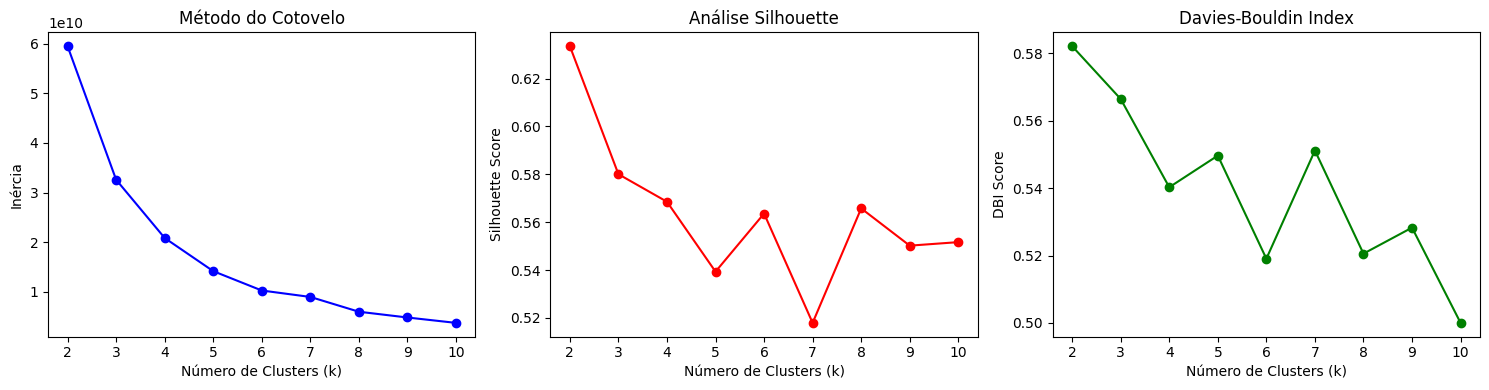

Resultados detalhados:
k=2: Inércia=59491759667 | Silhouette=0.634 | DBI=0.582
k=3: Inércia=32586372700 | Silhouette=0.580 | DBI=0.566
k=4: Inércia=20849636601 | Silhouette=0.569 | DBI=0.540
k=5: Inércia=14168419427 | Silhouette=0.539 | DBI=0.550
k=6: Inércia=10269801293 | Silhouette=0.564 | DBI=0.519
k=7: Inércia=8972619423 | Silhouette=0.518 | DBI=0.551
k=8: Inércia=5993716679 | Silhouette=0.566 | DBI=0.521
k=9: Inércia=4831530724 | Silhouette=0.550 | DBI=0.528
k=10: Inércia=3746214842 | Silhouette=0.552 | DBI=0.500


In [ ]:
# Configuração
k_range = range(2, 11)
inercia = []
silhouette_scores = []
dbi_scores = []

# Análise para diferentes valores de k
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(df_cluster)

    # Calcula métricas
    inercia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(df_cluster, labels))
    dbi_scores.append(davies_bouldin_score(df_cluster, labels))

# Plot dos resultados
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. Método do Cotovelo
axes[0].plot(k_range, inercia, 'bo-')
axes[0].set_xlabel('Número de Clusters (k)')
axes[0].set_ylabel('Inércia')
axes[0].set_title('Método do Cotovelo')

# 2. Silhouette Score (maior = melhor)
axes[1].plot(k_range, silhouette_scores, 'ro-')
axes[1].set_xlabel('Número de Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Análise Silhouette')

# 3. Davies-Bouldin Index (menor = melhor)
axes[2].plot(k_range, dbi_scores, 'go-')
axes[2].set_xlabel('Número de Clusters (k)')
axes[2].set_ylabel('DBI Score')
axes[2].set_title('Davies-Bouldin Index')

plt.tight_layout()
plt.show()

# Mostra valores numéricos
print("Resultados detalhados:")
for i, k in enumerate(k_range):
    print(f"k={k}: Inércia={inercia[i]:.0f} | Silhouette={silhouette_scores[i]:.3f} | DBI={dbi_scores[i]:.3f}")

### 5. Aplicação do K-means

In [ ]:
# Função para aplicar K-Means com k escolhido
def aplicar_kmeans(k, dados):
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(dados)
    return clusters, kmeans


k_escolhido = 4  # <==Valor de K
clusters, modelo_kmeans = aplicar_kmeans(k_escolhido, df_cluster)

# Adiciona os clusters ao DataFrame
df_cluster['cluster'] = clusters

print(f"✅ K-Means aplicado com k={k_escolhido}")
print(f"📊 Distribuição dos clusters:")
print(df_cluster['cluster'].value_counts().sort_index())



✅ K-Means aplicado com k=4
📊 Distribuição dos clusters:
cluster
0     6443
1     2439
2    10013
3      428
Name: count, dtype: int64


### 6. Análise de Centróides

In [ ]:
# CENTRÓIDES
print("🎯 Análise de  Centróides")
print("=" * 60)

# Lista de variáveis comportamentais
variaveis_todas = [ 'sedentarismo', 'alim_naosaudavel', 'consumo_alcool', 'tabagismo' ]

# Calcular médias reais de cada variável por cluster ATUAL
centroides_completos = df_cluster.groupby('cluster')[variaveis_todas].mean()

print("📊 MÉDIAS REAIS POR CLUSTER (valores entre 0-1):")
print(centroides_completos.round(3))

# Análise detalhada de cada cluster
print("\n🔍 PERFIL COMPLETO DE CADA CLUSTER:")
print("=" * 60)

for i in range(k_escolhido):
    cluster_data = df_cluster[df_cluster['cluster'] == i]
    tamanho = len(cluster_data)
    percentual = (tamanho / len(df_cluster)) * 100

    print(f"\n📊 CLUSTER {i} ({tamanho} pessoas - {percentual:.1f}%):")

    # Pegar médias deste cluster
    medias = centroides_completos.loc[i]

    print("   COMPORTAMENTOS DE RISCO:")
    for variavel, media in medias.items():
        if media > 0.3:  # Destaque comportamentos significativos
            status = "🚨 ALTO" if media > 0.7 else "⚠️  MODERADO"
            print(f"     {status} {variavel}: {media:.1%}")
        elif media < 0.1:
            print(f"     ✅ BAIXO {variavel}: {media:.1%}")

🎯 Análise de  Centróides
📊 MÉDIAS REAIS POR CLUSTER (valores entre 0-1):
         sedentarismo  alim_naosaudavel  consumo_alcool  tabagismo
cluster                                                           
0               0.221             0.133           0.132      0.156
1               0.229             0.160           0.173      0.175
2               0.236             0.078           0.095      0.154
3               0.290             0.213           0.215      0.231

🔍 PERFIL COMPLETO DE CADA CLUSTER:

📊 CLUSTER 0 (6443 pessoas - 33.3%):
   COMPORTAMENTOS DE RISCO:

📊 CLUSTER 1 (2439 pessoas - 12.6%):
   COMPORTAMENTOS DE RISCO:

📊 CLUSTER 2 (10013 pessoas - 51.8%):
   COMPORTAMENTOS DE RISCO:
     ✅ BAIXO alim_naosaudavel: 7.8%
     ✅ BAIXO consumo_alcool: 9.5%

📊 CLUSTER 3 (428 pessoas - 2.2%):
   COMPORTAMENTOS DE RISCO:


In [ ]:
# PERFIS COMPLETOS CORRETOS - MOSTRANDO TODAS AS VARIÁVEIS
print("🔍 PERFIL COMPLETO DE CADA CLUSTER:")
print("=" * 60)

for cluster in sorted(df_cluster['cluster'].unique()):
    cluster_data = df_cluster[df_cluster['cluster'] == cluster]
    count = len(cluster_data)
    percent = (count / len(df_cluster)) * 100

    print(f"\n📊 CLUSTER {cluster} ({count} pessoas - {percent:.1f}%):")
    print("   COMPORTAMENTOS DE RISCO:")

    # Mostra TODAS as 4 variáveis para cada cluster
    sedentarismo = cluster_data['sedentarismo'].mean()
    alim_naosaudavel = cluster_data['alim_naosaudavel'].mean()
    consumo_alcool = cluster_data['consumo_alcool'].mean()
    tabagismo = cluster_data['tabagismo'].mean()

    print(f"     🚨 Sedentarismo: {sedentarismo:.1%}")
    print(f"     🍔 Alimentação não saudável: {alim_naosaudavel:.1%}")
    print(f"     🍺 Consumo de álcool: {consumo_alcool:.1%}")
    print(f"     🚬 Tabagismo: {tabagismo:.1%}")

🔍 PERFIL COMPLETO DE CADA CLUSTER:

📊 CLUSTER 0 (6443 pessoas - 33.3%):
   COMPORTAMENTOS DE RISCO:
     🚨 Sedentarismo: 22.1%
     🍔 Alimentação não saudável: 13.3%
     🍺 Consumo de álcool: 13.2%
     🚬 Tabagismo: 15.6%

📊 CLUSTER 1 (2439 pessoas - 12.6%):
   COMPORTAMENTOS DE RISCO:
     🚨 Sedentarismo: 22.9%
     🍔 Alimentação não saudável: 16.0%
     🍺 Consumo de álcool: 17.3%
     🚬 Tabagismo: 17.5%

📊 CLUSTER 2 (10013 pessoas - 51.8%):
   COMPORTAMENTOS DE RISCO:
     🚨 Sedentarismo: 23.6%
     🍔 Alimentação não saudável: 7.8%
     🍺 Consumo de álcool: 9.5%
     🚬 Tabagismo: 15.4%

📊 CLUSTER 3 (428 pessoas - 2.2%):
   COMPORTAMENTOS DE RISCO:
     🚨 Sedentarismo: 29.0%
     🍔 Alimentação não saudável: 21.3%
     🍺 Consumo de álcool: 21.5%
     🚬 Tabagismo: 23.1%


In [ ]:
# ANÁLISE COMPLETA DO PERFIL DOS CLUSTERS (Demográfico + Comportamental)
print("🎯 Análise Completa do Perfil dos Clusters")
print("=" * 60)

# Lista de variáveis demográficas e comportamentais (excluindo 'ano' e 'pesorake')
variaveis_analise = [col for col in df_cluster.columns if col not in ['cluster', 'pesorake', 'ano']]

# Separar variáveis demográficas e comportamentais
variaveis_demograficas = ['sexo', 'faixa_esc', 'faixa_etaria', 'cor', 'trabalha']
variaveis_comportamentais_finais = ['tabagismo', 'consumo_alcool', 'sedentarismo', 'alim_naosaudavel']


# Calcular médias para variáveis comportamentais
perfil_clusters_comportamental = df_cluster.groupby('cluster')[variaveis_comportamentais_finais].mean()

print("📊 MÉDIAS DE COMPORTAMENTO POR CLUSTER:")
print(perfil_clusters_comportamental.round(3))


# Análise detalhada por cluster
print("\n🔍 PERFIL DETALHADO DE CADA CLUSTER:")
print("=" * 60)

for i in sorted(df_cluster['cluster'].unique()):
    cluster_data = df_cluster[df_cluster['cluster'] == i]
    tamanho = len(cluster_data)
    percentual = (tamanho / len(df_cluster)) * 100

    print(f"\n📊 CLUSTER {i} ({tamanho} pessoas - {percentual:.1f}%):")

    print("   CARACTERÍSTICAS DEMOGRÁFICAS PREDOMINANTES:")
    for var_dem in variaveis_demograficas:
        # Calculate and print the mode (most frequent value) and its count/percentage
        if var_dem in cluster_data.columns:
            mode_value = cluster_data[var_dem].mode()
            if not mode_value.empty:
                mode = mode_value[0]
                count = cluster_data[var_dem].value_counts().get(mode, 0)
                total = cluster_data[var_dem].count() # Use count() to exclude NaNs if any (though should be filled)
                percentage = (count / total) * 100 if total > 0 else 0
                print(f"     - {var_dem}: Predominante = {mode} ({percentage:.1f}%)")
            else:
                 print(f"     - {var_dem}: N/A (Moda não encontrada)")
        else:
            print(f"     - {var_dem}: Coluna não encontrada")


    print("\n   COMPORTAMENTOS DE RISCO MÉDIOS:")
    if i in perfil_clusters_comportamental.index:
      medias_comportamentais = perfil_clusters_comportamental.loc[i]
      for variavel, media in medias_comportamentais.items():
          print(f"     - {variavel}: {media:.3f}")
    else:
      print("     - Dados de comportamento não disponíveis para este cluster.")

🎯 Análise Completa do Perfil dos Clusters
📊 MÉDIAS DE COMPORTAMENTO POR CLUSTER:
         tabagismo  consumo_alcool  sedentarismo  alim_naosaudavel
cluster                                                           
0            0.156           0.132         0.221             0.133
1            0.175           0.173         0.229             0.160
2            0.154           0.095         0.236             0.078
3            0.231           0.215         0.290             0.213

🔍 PERFIL DETALHADO DE CADA CLUSTER:

📊 CLUSTER 0 (6443 pessoas - 33.3%):
   CARACTERÍSTICAS DEMOGRÁFICAS PREDOMINANTES:
     - sexo: Predominante = 2 (57.1%)
     - faixa_esc: Predominante = 1 (43.1%)
     - faixa_etaria: Predominante = 2 (24.1%)
     - cor: Predominante = 1 (53.8%)
     - trabalha: Predominante = 1 (67.3%)

   COMPORTAMENTOS DE RISCO MÉDIOS:
     - tabagismo: 0.156
     - consumo_alcool: 0.132
     - sedentarismo: 0.221
     - alim_naosaudavel: 0.133

📊 CLUSTER 1 (2439 pessoas - 12.6%):
   CAR

### 7. Análise da Importância das Variábeis (xAI)

🎯 SHAP - ANÁLISE DE IMPORTÂNCIA DAS VARIÁVEIS
📊 Dimensões: (2000, 4)
📊 Variáveis: ['sedentarismo', 'tabagismo', 'alim_naosaudavel', 'consumo_alcool']
📊 Treino: (1400, 4), Teste: (600, 4)

📈 MÉTRICAS DO MODELO
✅ Acurácia: 0.5283 (52.83%)

📋 RELATÓRIO DE CLASSIFICAÇÃO:
              precision    recall  f1-score   support

           0       0.32      0.06      0.10       196
           1       0.67      0.03      0.05        71
           2       0.54      0.95      0.69       320
           3       0.00      0.00      0.00        13

    accuracy                           0.53       600
   macro avg       0.38      0.26      0.21       600
weighted avg       0.47      0.53      0.41       600

🎯 MATRIZ DE CONFUSÃO:
[[ 12   0 184   0]
 [  7   2  62   0]
 [ 16   1 303   0]
 [  2   0  11   0]]

✅ SHAP calculado com sucesso!

📊 BAR PLOT GLOBAL


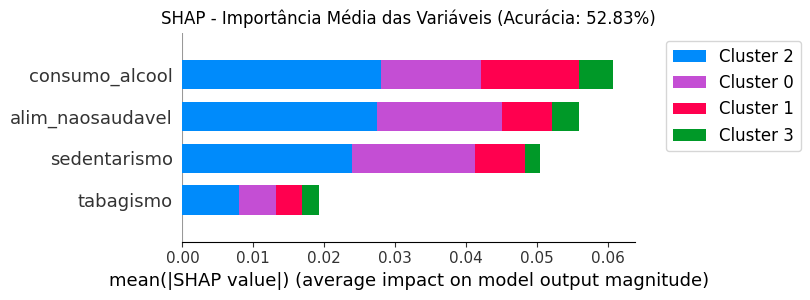

In [ ]:
print("🎯 SHAP - ANÁLISE DE IMPORTÂNCIA DAS VARIÁVEIS")
print("=" * 50)

# Prepara dados com 4 variáveis
variaveis_comportamentais = ['sedentarismo','tabagismo', 'alim_naosaudavel', 'consumo_alcool']
# Use df_processed_for_clustering and the clusters

# Ensure 'cluster' column exists in df_cluster
if 'cluster' not in df_cluster.columns:
    print("⚠️ Coluna 'cluster' não encontrada em df_cluster. Reexecutando K-Means...")
    # Reapply K-Means if cluster column is missing
    # This part assumes 'k_escolhido' and 'aplicar_kmeans' are defined
    # If not, the user needs to re-run the K-Means application cell (e.g., 4DF-V1t4ea_e)
    if 'k_escolhido' in locals() and 'aplicar_kmeans' in locals():
        clusters, modelo_kmeans = aplicar_kmeans(k_escolhido, df_cluster[variaveis_comportamentais]) # Use the same features as X_sample
        df_cluster['cluster'] = clusters
        print("✅ K-Means reexecutado e coluna 'cluster' adicionada.")
    else:
        print("❌ K-Means não pode ser reexecutado automaticamente. Por favor, execute a célula '4DF-V1t4ea_e' manualmente.")
        # If we cannot automatically fix, raise an error or exit to prevent further issues
        raise KeyError("A coluna 'cluster' é necessária para a análise SHAP e não pôde ser gerada automaticamente.")

X_sample = df_processed_for_clustering[variaveis_comportamentais].sample(n=2000, random_state=42)
y_sample = df_cluster.loc[X_sample.index, 'cluster'] # Use 'cluster' column from df_cluster

print(f"📊 Dimensões: {X_sample.shape}")
print(f"📊 Variáveis: {variaveis_comportamentais}")

# DIVISÃO EM TREINO E TESTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(
    X_sample, y_sample, test_size=0.3, random_state=42, stratify=y_sample
)

print(f"📊 Treino: {X_train.shape}, Teste: {X_test.shape}")

# Modelo para SHAP
rf_shap = RandomForestClassifier(n_estimators=50, random_state=42)
rf_shap.fit(X_train, y_train)

# PREDIÇÕES E MÉTRICAS
y_pred = rf_shap.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("\n📈 MÉTRICAS DO MODELO")
print("=" * 50)
print(f"✅ Acurácia: {accuracy:.4f} ({accuracy*100:.2f}%)")

# RELATÓRIO DE CLASSIFICAÇÃO DETALHADO
print("\n📋 RELATÓRIO DE CLASSIFICAÇÃO:")
print("=" * 50)
print(classification_report(y_test, y_pred))

# MATRIZ DE CONFUSÃO
print("🎯 MATRIZ DE CONFUSÃO:")
print("=" * 50)
cm = confusion_matrix(y_test, y_pred)
print(cm)

# SHAP values (usando dados de treino para o explainer)
explainer = shap.TreeExplainer(rf_shap)
shap_values = explainer.shap_values(X_test)  # Usando X_test para análise SHAP

print("\n✅ SHAP calculado com sucesso!")

# BAR PLOT GLOBAL (sempre funciona)
print("\n📊 BAR PLOT GLOBAL")
print("=" * 50)

plt.figure(figsize=(20, 12))
shap.summary_plot(shap_values, X_test, feature_names=variaveis_comportamentais,
                 plot_type="bar", show=False, class_names=[f'Cluster {i}' for i in range(len(shap_values))])

# CORREÇÃO DA LEGENDA SOBREPOSTA
ax = plt.gca()
legenda = ax.legend_
if legenda is not None:
    # Reposicionar a legenda para fora do gráfico
    legenda.set_bbox_to_anchor((1.05, 1))
    legenda.set_frame_on(True)

plt.title(f'SHAP - Importância Média das Variáveis (Acurácia: {accuracy*100:.2f}%)')
plt.tight_layout()
plt.subplots_adjust(right=0.8)  # Dar espaço para a legenda
plt.show()

🎯 SHAP - ANÁLISE INDIVIDUAL POR CLUSTER (Bar Plot com Direção de Impacto)


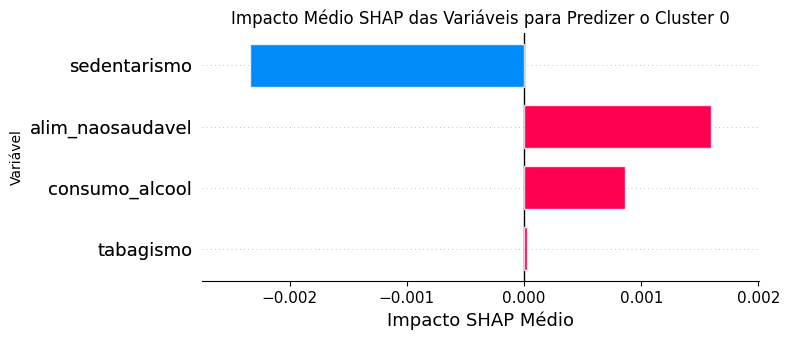

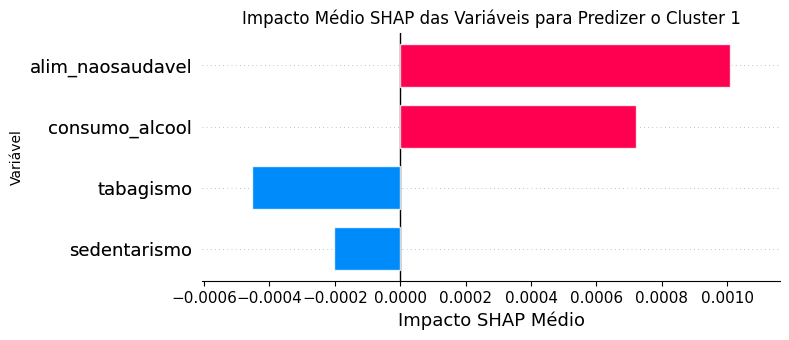

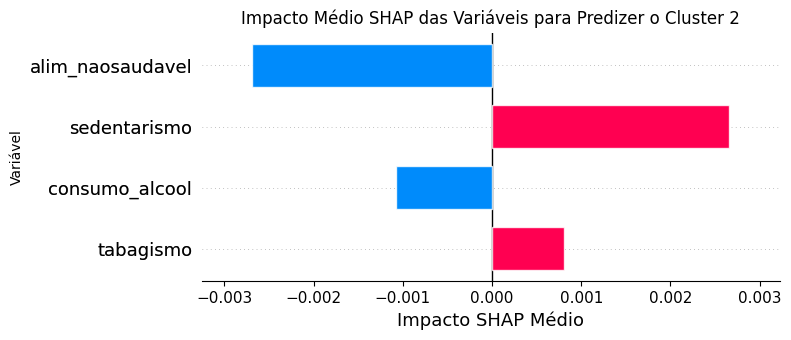

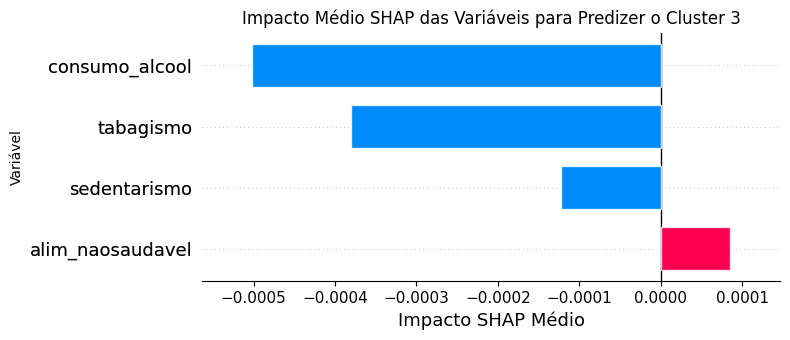


✅ Gráficos de impacto SHAP médio por cluster gerados.
ℹ️ As barras representam o impacto médio de cada variável na predição do cluster. Barras positivas indicam que a variável aumenta a probabilidade de um indivíduo pertencer a esse cluster, enquanto barras negativas diminuem.
ℹ️ A função `shap.plots.bar` por padrão usa cores (vermelho/azul) para indicar a direção do impacto (positivo/negativo), o que é mais informativo do que uma cor uniforme. Não suporta gradientes *dentro* de cada barra. Os valores numéricos das barras foram removidos conforme solicitado.


In [ ]:
import matplotlib.pyplot as plt
import shap
import numpy as np

print("🎯 SHAP - ANÁLISE INDIVIDUAL POR CLUSTER (Bar Plot com Direção de Impacto)")
print("=" * 70)

# Verifica se k_escolhido, X_test, variaveis_comportamentais e shap_values estão disponíveis
if 'k_escolhido' not in locals() or 'X_test' not in locals() or 'variaveis_comportamentais' not in locals() or 'shap_values' not in locals() or 'explainer' not in locals():
    print("❌ Variáveis necessárias (k_escolhido, X_test, variaveis_comportamentais, shap_values, explainer) não encontradas. Por favor, execute as células anteriores, incluindo a análise SHAP.")
else:
    for i in range(k_escolhido):
        # Extrai os valores SHAP para o cluster atual
        # shap_values[:, :, i] retorna um array (num_samples, num_features) para prever o cluster i
        shap_values_for_cluster = shap_values[:, :, i]

        # Calcula o valor SHAP médio para cada feature no cluster atual
        mean_shap_values_per_feature = shap_values_for_cluster.mean(axis=0)

        # Cria um objeto Explanation para o cluster atual
        explanation_for_cluster = shap.Explanation(
            values=mean_shap_values_per_feature,
            base_values=explainer.expected_value[i],
            feature_names=variaveis_comportamentais
        )

        plt.figure(figsize=(10, 6))
        # shap.plots.bar agora recebe um objeto Explanation completo
        shap.plots.bar(explanation_for_cluster,
                       show=False)

        # Obtém o eixo atual para manipular os elementos de texto
        ax = plt.gca()

        # Remove os rótulos de texto numéricos das barras (se existirem)
        for t in ax.texts:
            t.set_visible(False)

        plt.title(f'Impacto Médio SHAP das Variáveis para Predizer o Cluster {i}')
        plt.xlabel('Impacto SHAP Médio')
        plt.ylabel('Variável')
        plt.tight_layout()
        plt.show()

    print("\n✅ Gráficos de impacto SHAP médio por cluster gerados.")
    print("ℹ️ As barras representam o impacto médio de cada variável na predição do cluster. Barras positivas indicam que a variável aumenta a probabilidade de um indivíduo pertencer a esse cluster, enquanto barras negativas diminuem.")
    print("ℹ️ A função `shap.plots.bar` por padrão usa cores (vermelho/azul) para indicar a direção do impacto (positivo/negativo), o que é mais informativo do que uma cor uniforme. Não suporta gradientes *dentro* de cada barra. Os valores numéricos das barras foram removidos conforme solicitado.")

In [ ]:
# EXTRAIR VALORES SHAP PARA ANÁLISE
print("📊 EXTRAÇÃO DOS VALORES SHAP")
print("=" * 50)

# Formato completo do SHAP
print(f"📈 Formato do array SHAP: {np.array(shap_values).shape}")
print(f"🔢 Dimensões: {np.array(shap_values).shape[0]} amostras × {np.array(shap_values).shape[1]} variáveis × {np.array(shap_values).shape[2]} clusters")

# Valores SHAP médios por cluster e variável
print("\n🎯 VALORES SHAP MÉDIOS POR CLUSTER E VARIÁVEL:")
shap_medios = np.mean(shap_values, axis=0)  # Média sobre as amostras
df_shap_medios = pd.DataFrame(shap_medios,
                             index=variaveis_comportamentais,
                             columns=[f'Cluster_{i}' for i in range(k_escolhido)]) # Use k_escolhido for columns
print(df_shap_medios.round(4))

# Valores SHAP médios absolutos (importância)
print("\n📊 IMPORTÂNCIA SHAP MÉDIA (VALORES ABSOLUTOS):")
shap_absolutos = np.abs(shap_values).mean(axis=0)
df_shap_importancia = pd.DataFrame(shap_absolutos,
                                  index=variaveis_comportamentais,
                                  columns=[f'Cluster_{i}' for i in range(k_escolhido)]) # Use k_escolhido for columns
print(df_shap_importancia.round(4))

# Ranking de importância por cluster
print("\n🏆 RANKING DE IMPORTÂNCIA POR CLUSTER:")
for i in range(k_escolhido): # Iterate up to k_escolhido
    print(f"\n📊 CLUSTER {i}:")
    importancia_cluster = df_shap_importancia[f'Cluster_{i}']
    ranking = importancia_cluster.sort_values(ascending=False)

    for j, (variavel, importancia) in enumerate(ranking.items(), 1):
        impacto = df_shap_medios.loc[variavel, f'Cluster_{i}']
        direcao = "🔼 +" if impacto > 0 else "🔽 -" if impacto < 0 else "➡️  ~"
        print(f"   {j}. {variavel}: {importancia:.4f} (impacto: {impacto:.4f} {direcao})")

# Estatísticas gerais
print("\n📈 ESTATÍSTICAS GERAIS SHAP:")
print(f"• Maior valor SHAP positivo: {np.max(shap_values):.4f}")
print(f"• Menor valor SHAP negativo: {np.min(shap_values):.4f}")
print(f"• Média geral dos valores SHAP: {np.mean(shap_values):.4f}")
print(f"• Desvio padrão geral: {np.std(shap_values):.4f}")

📊 EXTRAÇÃO DOS VALORES SHAP
📈 Formato do array SHAP: (600, 4, 4)
🔢 Dimensões: 600 amostras × 4 variáveis × 4 clusters

🎯 VALORES SHAP MÉDIOS POR CLUSTER E VARIÁVEL:
                  Cluster_0  Cluster_1  Cluster_2  Cluster_3
sedentarismo        -0.0023    -0.0002     0.0027    -0.0001
tabagismo            0.0000    -0.0005     0.0008    -0.0004
alim_naosaudavel     0.0016     0.0010    -0.0027     0.0001
consumo_alcool       0.0009     0.0007    -0.0011    -0.0005

📊 IMPORTÂNCIA SHAP MÉDIA (VALORES ABSOLUTOS):
                  Cluster_0  Cluster_1  Cluster_2  Cluster_3
sedentarismo         0.0174     0.0070     0.0240     0.0021
tabagismo            0.0051     0.0038     0.0080     0.0023
alim_naosaudavel     0.0176     0.0070     0.0275     0.0039
consumo_alcool       0.0140     0.0139     0.0281     0.0049

🏆 RANKING DE IMPORTÂNCIA POR CLUSTER:

📊 CLUSTER 0:
   1. alim_naosaudavel: 0.0176 (impacto: 0.0016 🔼 +)
   2. sedentarismo: 0.0174 (impacto: -0.0023 🔽 -)
   3. consumo_alcool: 

### 11. Calcular a Taxa de Prevalência anual por perfil

In [ ]:
# Calcula a taxa de prevalência anual por perfil
prevalencia_anual = df_cluster.groupby(['ano', 'cluster']).agg({
    'pesorake': 'sum',  # Soma dos pesos amostrais por cluster
}).reset_index()

# Calcula o total de pesos por ano
total_pesos_ano = df_cluster.groupby('ano')['pesorake'].sum().reset_index()
total_pesos_ano.columns = ['ano', 'total_pesos_ano']

# Junta com os totais anuais
prevalencia_anual = prevalencia_anual.merge(total_pesos_ano, on='ano')

# Calcula a taxa de prevalência (por 100.000 habitantes)
prevalencia_anual['taxa_prevalencia'] = (prevalencia_anual['pesorake'] / prevalencia_anual['total_pesos_ano']) * 100000

# Arredonda e formata
prevalencia_anual['taxa_prevalencia'] = prevalencia_anual['taxa_prevalencia'].round(2)

print("📊 TAXA DE PREVALÊNCIA ANUAL POR PERFIL:")
print("=" * 60)
print(prevalencia_anual)


📊 TAXA DE PREVALÊNCIA ANUAL POR PERFIL:
     ano  cluster      pesorake  total_pesos_ano  taxa_prevalencia
0   2006        0  3.266703e+06     7.217924e+06          45258.20
1   2006        1  1.384694e+06     7.217924e+06          19184.10
2   2006        2  2.293373e+06     7.217924e+06          31773.31
3   2006        3  2.731543e+05     7.217924e+06           3784.39
4   2007        0  3.054449e+06     8.469519e+06          36064.02
5   2007        1  2.106348e+06     8.469519e+06          24869.74
6   2007        2  2.824675e+06     8.469519e+06          33351.06
7   2007        3  4.840480e+05     8.469519e+06           5715.18
8   2008        0  2.970804e+06     7.973763e+06          37257.24
9   2008        1  1.843819e+06     7.973763e+06          23123.58
10  2008        2  2.823151e+06     7.973763e+06          35405.50
11  2008        3  3.359889e+05     7.973763e+06           4213.68
12  2009        0  2.601188e+06     8.049932e+06          32313.17
13  2009        1  1.9

In [ ]:
# Cria tabela pivot com taxas de prevalência por ano e perfil
tabela_correlacao = prevalencia_anual.pivot(
    index='ano',
    columns='cluster',
    values='taxa_prevalencia'
).reset_index()

# Renomeia as colunas para melhor identificação
tabela_correlacao.columns = ['ano'] + [f'perfil_{i}' for i in range(k_escolhido)]

print("📊 PLANILHA PARA CORRELAÇÃO COM CÂNCER:")
print("=" * 50)
print(tabela_correlacao)

# Salva a planilha
tabela_correlacao.to_csv('prevalencia_comportamentos_perfis.csv', index=False, encoding='utf-8')

print(f"\n✅ Arquivo salvo: 'prevalencia_comportamentos_perfis.csv'")
print(f"📋 Estrutura: Ano + Taxas de prevalência dos {k_escolhido} perfis")
print(f"📊 Dimensões: {tabela_correlacao.shape}")

📊 PLANILHA PARA CORRELAÇÃO COM CÂNCER:
    ano  perfil_0  perfil_1  perfil_2  perfil_3
0  2006  45258.20  19184.10  31773.31   3784.39
1  2007  36064.02  24869.74  33351.06   5715.18
2  2008  37257.24  23123.58  35405.50   4213.68
3  2009  32313.17  23869.96  35371.49   8445.38
4  2010  37435.54  24294.64  30735.56   7534.26
5  2011  43035.37  22818.05  29541.76   4604.83
6  2012  34912.68  30265.15  22843.55  11978.62
7  2013  46128.35  24745.19  24544.65   4581.80
8  2014  38678.86  30360.50  14787.19  16173.44
9  2015  40224.55  25255.23  25854.44   8665.78

✅ Arquivo salvo: 'prevalencia_comportamentos_perfis.csv'
📋 Estrutura: Ano + Taxas de prevalência dos 4 perfis
📊 Dimensões: (10, 5)


In [ ]:
# Calcula prevalência ponderada dos comportamentos de risco isolados
comportamentos_isolados = ['sedentarismo', 'alim_naosaudavel', 'consumo_alcool', 'tabagismo']

prevalencia_comportamentos = []

for comportamento in comportamentos_isolados:
    # Calcula a prevalência ponderada por ano para cada comportamento
    prevalencia_ano = df_cluster.groupby('ano').apply(
        lambda x: (x[comportamento] * x['pesorake']).sum() / x['pesorake'].sum()
    ).reset_index()

    prevalencia_ano.columns = ['ano', comportamento]
    prevalencia_ano[comportamento] = (prevalencia_ano[comportamento] * 100).round(2)  # Em percentual

    prevalencia_comportamentos.append(prevalencia_ano)

# Combina todos os comportamentos em uma única tabela
tabela_final = prevalencia_comportamentos[0]
for i in range(1, len(comportamentos_isolados)):
    tabela_final = tabela_final.merge(prevalencia_comportamentos[i], on='ano')

print("📊 PREVALÊNCIA PONDERADA DOS COMPORTAMENTOS DE RISCO ISOLADOS:")
print("=" * 70)
print(tabela_final)

# Salva os resultados
tabela_final.to_csv('prevalencia_comportamentos_isolados.csv', index=False, encoding='utf-8')

print(f"\n✅ Arquivo salvo: 'prevalencia_comportamentos_isolados.csv'")
print(f"📋 Estrutura: Ano + Prevalência (%) de cada comportamento isolado")
print(f"📊 Dimensões: {tabela_final.shape}")

📊 PREVALÊNCIA PONDERADA DOS COMPORTAMENTOS DE RISCO ISOLADOS:
    ano  sedentarismo  alim_naosaudavel  consumo_alcool  tabagismo
0  2006         23.28             20.08           11.47      18.22
1  2007         21.81             14.89           12.37      18.35
2  2008         21.67             12.41           12.94      18.33
3  2009         21.63             12.84           14.50      17.05
4  2010         24.71             12.90           14.82      18.62
5  2011         22.08             13.38           13.91      18.07
6  2012         24.24             12.87           16.87      15.52
7  2013         26.46             10.66           14.57      14.91
8  2014         22.38             11.09           14.18      14.13
9  2015         21.38             13.16           14.81      13.74

✅ Arquivo salvo: 'prevalencia_comportamentos_isolados.csv'
📋 Estrutura: Ano + Prevalência (%) de cada comportamento isolado
📊 Dimensões: (10, 5)


In [ ]:
# Carregar o arquivo CSV existente com a prevalência de comportamentos isolados
try:
    tabela_comportamentos_isolados = pd.read_csv('prevalencia_comportamentos_isolados.csv')
    print("✅ Arquivo 'prevalencia_comportamentos_isolados.csv' carregado.")
except FileNotFoundError:
    print("❌ Arquivo 'prevalencia_comportamentos_isolados.csv' não encontrado.")
    tabela_comportamentos_isolados = None

# Verificar se df_cluster existe e contém a coluna 'cluster'
if tabela_comportamentos_isolados is not None and 'df_cluster' in locals() and 'cluster' in df_cluster.columns:
    # Juntar a coluna de cluster ao dataframe de prevalência por ano
    # Como a prevalência por ano foi calculada a partir de df_cluster agrupado por ano,
    # precisamos garantir que a junção faça sentido.
    # Vamos adicionar a contagem de pessoas em cada cluster por ano ao invés da coluna 'cluster' direta.

    # Calcular a contagem de pessoas por cluster e ano
    contagem_cluster_ano = df_cluster.groupby(['ano', 'cluster']).size().unstack(fill_value=0).reset_index()

    # Renomear as colunas de cluster para melhor identificação
    contagem_cluster_ano.columns = ['ano'] + [f'contagem_cluster_{i}' for i in contagem_cluster_ano.columns[1:]]

    # Juntar a contagem de clusters anuais com a tabela de comportamentos isolados
    tabela_combinada = tabela_comportamentos_isolados.merge(contagem_cluster_ano, on='ano', how='left')

    # Preencher possíveis NaNs se algum ano não tiver todos os clusters (improvável, mas seguro)
    tabela_combinada.fillna(0, inplace=True)


    print("\n📊 Tabela combinada (Prevalência de Comportamentos Isolados + Contagem de Pessoas por Cluster e Ano):")
    display(tabela_combinada.head())

    # Salvar a nova planilha
    output_filename_combinado = 'prevalencia_comportamentos_isolados_com_clusters.csv'
    tabela_combinada.to_csv(output_filename_combinado, index=False, encoding='utf-8')

    print(f"\n✅ Nova planilha salva: '{output_filename_combinado}'")
    print(f"📋 Estrutura: Ano + Prevalência de comportamentos isolados (%) + Contagem de pessoas por cluster")
    print(f"📊 Dimensões: {tabela_combinada.shape}")

    # Add the cluster column to microdados_vigitelsp_processado.csv
    # Since df_cluster already contains the 'cluster' column, we just need to save it
    output_filename_processado = 'microdados_vigitelsp_processado.csv'
    df_cluster.to_csv(output_filename_processado, index=False, encoding='utf-8')
    print(f"\n✅ DataFrame df_cluster (com a coluna 'cluster') salvo em '{output_filename_processado}'")
    print(f"📊 Primeiras 5 linhas do dataframe salvo:")
    display(df_cluster.head())


elif tabela_comportamentos_isolados is None:
    print("⚠️ Não foi possível prosseguir pois o arquivo 'prevalencia_comportamentos_isolados.csv' não foi carregado.")
else:
    print("⚠️ O dataframe 'df_cluster' ou a coluna 'cluster' não foram encontrados. Por favor, execute as células anteriores.")

✅ Arquivo 'prevalencia_comportamentos_isolados.csv' carregado.

📊 Tabela combinada (Prevalência de Comportamentos Isolados + Contagem de Pessoas por Cluster e Ano):


,ano,sedentarismo,alim_naosaudavel,consumo_alcool,tabagismo,contagem_cluster_0,contagem_cluster_1,contagem_cluster_2,contagem_cluster_3
0,2006,23.28,20.08,11.47,18.22,671,169,1023,19
1,2007,21.81,14.89,12.37,18.35,610,259,1233,34
2,2008,21.67,12.41,12.94,18.33,581,211,1199,22
3,2009,21.63,12.84,14.50,17.05,510,228,1225,47
4,2010,24.71,12.90,14.82,18.62,630,244,1093,41



✅ Nova planilha salva: 'prevalencia_comportamentos_isolados_com_clusters.csv'
📋 Estrutura: Ano + Prevalência de comportamentos isolados (%) + Contagem de pessoas por cluster
📊 Dimensões: (10, 9)

✅ DataFrame df_cluster (com a coluna 'cluster') salvo em 'microdados_vigitelsp_processado.csv'
📊 Primeiras 5 linhas do dataframe salvo:


,ano,sexo,faixa_esc,faixa_etaria,cor,trabalha,tabagismo,consumo_alcool,pesorake,sedentarismo,alim_naosaudavel,cluster
0,2013,2,1,4,1,2,0,0,6294.8232,1,0,0
1,2013,2,1,5,1,1,0,0,3472.6157,0,0,2
2,2013,2,1,6,1,2,1,0,4301.5508,0,0,0
3,2013,2,1,4,1,2,0,0,4501.4429,1,0,0
4,2013,2,3,2,4,1,0,0,4424.3062,0,0,0
